In [1]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.ticker as tk
import matplotlib.patches as mpatches
from scipy import stats

In [3]:
datav925 = xr.open_mfdataset('E:\Daily Reanalisis ERA 5 v2/v925\*.nc',combine = 'by_coords')
datau925 = xr.open_mfdataset('E:\Daily Reanalisis ERA 5 v2/u925\*.nc',combine = 'by_coords')
datamslp = xr.open_mfdataset('E:\Daily Reanalisis ERA 5 v2/mslp\*.nc',combine = 'by_coords')/100
datasst = xr.open_mfdataset('E:\Data OISST\*.nc',combine = 'by_coords')

In [4]:
datau925=datau925.sel(time=slice('1981-09-01T00:00:00.000000000','2021-05-31T00:00:00.000000000')).rolling(time=3, center=True).mean()
monthlyclimu925=datau925['u'].groupby('time.month').mean('time')
datav925=datav925.sel(time=slice('1981-09-01T00:00:00.000000000','2021-05-31T00:00:00.000000000')).rolling(time=3, center=True).mean()
monthlyclimv925=datav925['v'].groupby('time.month').mean('time')
datamslp=datamslp.sel(time=slice('1981-09-01T00:00:00.000000000','2021-05-31T00:00:00.000000000')).rolling(time=3, center=True).mean()
monthlyclimmslp=datamslp['msl'].groupby('time.month').mean('time')
datasst=datasst.sel(time=slice('1981-09-01T00:00:00.000000000','2021-05-31T00:00:00.000000000')).rolling(time=3, center=True).mean()
monthlyclim=datasst['sst'].groupby('time.month').mean('time')

In [5]:
monthlyclimmslp=monthlyclimmslp.load()
monthlyclimv925=monthlyclimv925.load()
monthlyclimu925=monthlyclimu925.load()
monthlyclim=monthlyclim.load()

In [7]:
datav10 = xr.open_mfdataset('E:\Daily Reanalisis ERA 5 v2/v10\*.nc',combine = 'by_coords')

In [8]:
datav10=datav10.sel(time=slice('1981-09-01T00:00:00.000000000','2021-05-31T00:00:00.000000000')).rolling(time=3, center=True).mean()
dataws=(datau925['u']**2+datav925['v']**2)**0.5

In [9]:
cens=datav10['v10'].sel(lat= slice(-5,0), lon=slice(105,110)).mean(dim=('lat', 'lon'))
cs=dataws.sel(lat= slice(5,10), lon=slice(107,115)).mean(dim=('lat', 'lon'))

In [10]:
#CENS Daily Clim
censdayclim=cens.rolling(time=15, center=True).mean().sel(time=cens.time.dt.month.isin([1, 2, 3, 11, 12]))
month_day_str=xr.DataArray(censdayclim.indexes['time'].strftime('%m-%d'), coords=censdayclim['time'].coords, name='month_day_str')
censdayclim=censdayclim.groupby(month_day_str).mean('time')
censdayclim=censdayclim.drop_sel(month_day_str=["02-29"]).load()

In [11]:
#CS Daily Clim
csdayclim=cs.rolling(time=15, center=True).mean().sel(time=cs.time.dt.month.isin([1, 2, 3, 11, 12]))
month_day_str=xr.DataArray(csdayclim.indexes['time'].strftime('%m-%d'), coords=csdayclim['time'].coords, name='month_day_str')
csdayclim=csdayclim.groupby(month_day_str).mean('time')
csdayclim=csdayclim.drop_sel(month_day_str=["02-29"]).load()

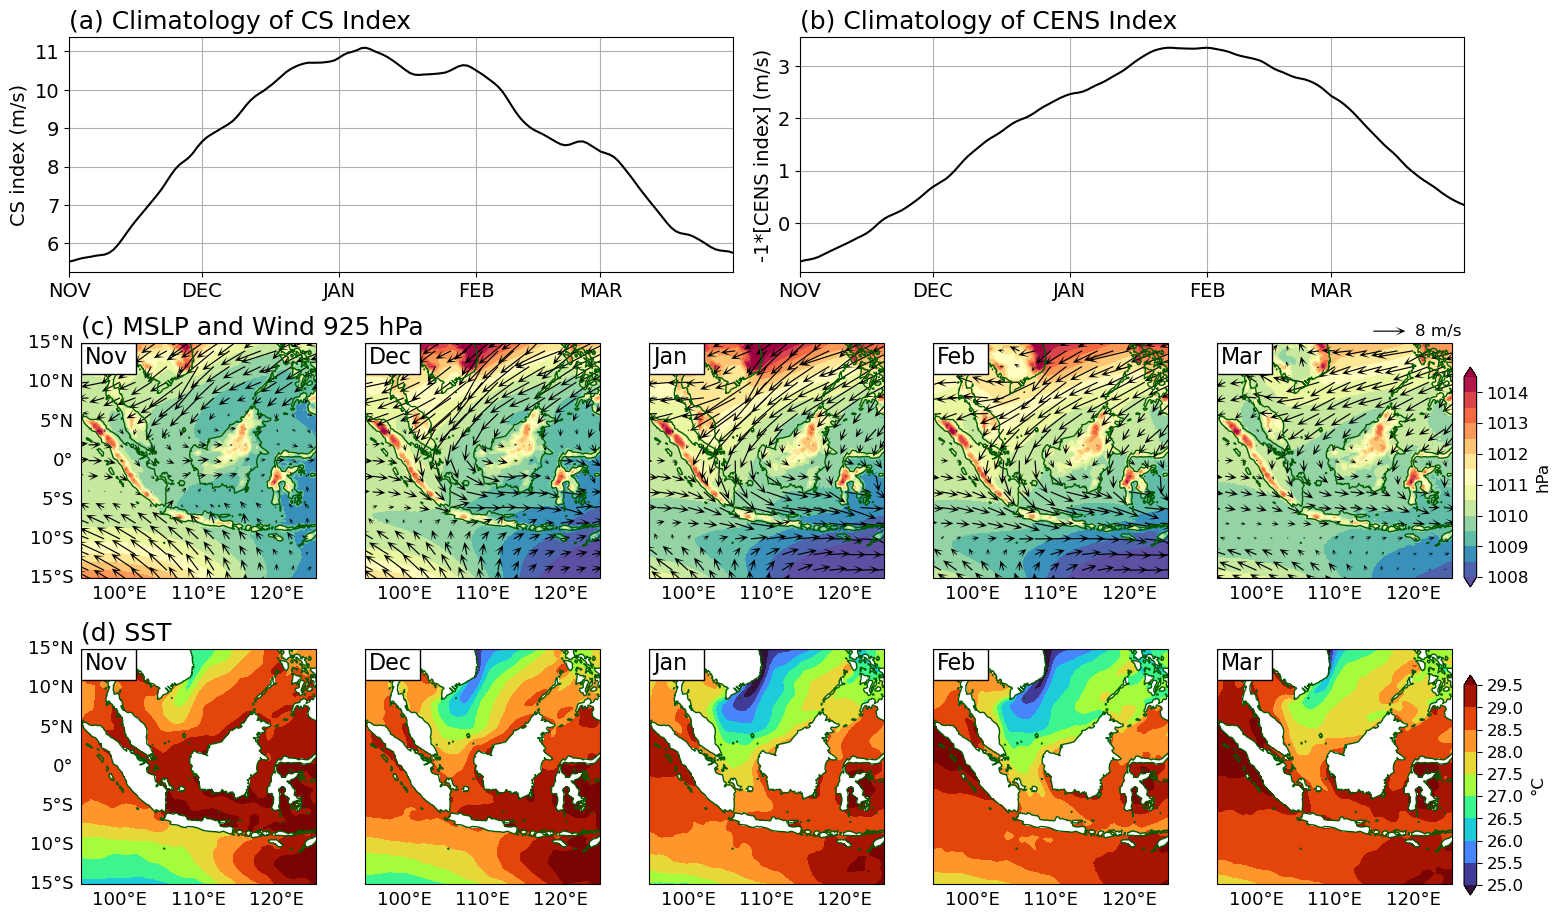

In [16]:
fig=plt.figure(figsize=(18,11))
plt.subplot(3,2,1)
x=np.concatenate((csdayclim['month_day_str'][90:].values,csdayclim['month_day_str'][0:90].values))
y=np.concatenate((csdayclim[90:].values,csdayclim[0:90].values))
plt.plot(x,y, c='k')
plt.xticks(['11-01','12-01','01-01','02-01','03-01'], ['NOV','DEC','JAN','FEB','MAR'], fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('CS index (m/s)', fontsize=14)
plt.title('(a) Climatology of CS Index', loc='left', fontsize=18)
plt.grid()
plt.xlim(['11-01','03-31'])

plt.subplot(3,2,2)
x=np.concatenate((censdayclim['month_day_str'][90:].values,censdayclim['month_day_str'][0:90].values))
y=np.concatenate((censdayclim[90:].values*-1,censdayclim[0:90].values*-1))
plt.plot(x,y, c='k')
plt.xticks(['11-01','12-01','01-01','02-01','03-01'], ['NOV','DEC','JAN','FEB','MAR'], fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('-1*[CENS index] (m/s)', fontsize=14)
plt.title('(b) Climatology of CENS Index', loc='left', fontsize=18)
plt.grid()
plt.xlim(['11-01','03-31'])


for sbp, k,mn,mname in zip([6,7,8,9,10], range(5),[11,12,1,2,3],['Nov','Dec','Jan','Feb','Mar']):
    axs=plt.subplot(3,5,sbp, projection=ccrs.PlateCarree())
    axs.set_extent([95, 125, -15, 15])
    gl=axs.gridlines(draw_labels=True,linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    #gl.xlocator = tk.FixedLocator([100, 110, 120])
    #gl.ylocator = tk.FixedLocator([-20, 0, 20, 40])
    if k>0:
        gl.left_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    valuetp=monthlyclimmslp.sel(month=mn)
    plotvaltp=axs.contourf(valuetp['lon'], valuetp['lat'], valuetp, transform=ccrs.PlateCarree(),
              cmap='Spectral_r',
              levels=np.arange(1008,1015, 0.5), 
              extend='both'
              )
    
    uu=monthlyclimu925.sel(month=mn)
    vv=monthlyclimv925.sel(month=mn)
    x,y=np.meshgrid(uu['lon'], uu['lat'])
    skip = 8
    Qwdg=axs.quiver(x[::skip, ::skip], y[::skip, ::skip], uu[::skip, ::skip], vv[::skip, ::skip], color='k', scale=25 ,scale_units='inches', width=0.005, headlength=8.5, headwidth=7.5, headaxislength=4)

    axs.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
    

    longitude1, latitude1 = 95, 11
    longitude2, latitude2 = 102, 15

    axs.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                    facecolor='white', edgecolor='k', linewidth=1, zorder=3,
                                    transform=ccrs.PlateCarree()))
    axs.text(95.5,12.3,mname,fontsize=16, c='k')
    if k==0:
        axs.set_title('(c) MSLP and Wind 925 hPa', loc='left', fontsize=18)
        
    if k==4:
            qk = plt.quiverkey(Qwdg, 
                  0.8, 1.05,                  
                  8,str(8)+' m/s',   
                  labelpos='E',               
                  coordinates='axes', fontproperties={'size':12}
                   )
    

cbar_tp = fig.add_axes([0.9, 0.38, 0.007, 0.2])
cbartp = fig.colorbar(plotvaltp, cax=cbar_tp)
cbartp.ax.tick_params(labelsize=12)
cbartp.ax.set_ylabel('hPa', fontsize=12, labelpad=5)

for sbp, k,mn,mname in zip([11,12,13,14,15], range(5),[11,12,1,2,3],['Nov','Dec','Jan','Feb','Mar']):
    axs=plt.subplot(3,5,sbp, projection=ccrs.PlateCarree())
    axs.set_extent([95, 125, -15, 15])
    gl=axs.gridlines(draw_labels=True,linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    #gl.xlocator = tk.FixedLocator([100, 110, 120])
    #gl.ylocator = tk.FixedLocator([-20, 0, 20, 40])
    if k>0:
        gl.left_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    valuetp=monthlyclim.sel(month=mn)
    plotvaltp=axs.contourf(valuetp['lon'], valuetp['lat'], valuetp, transform=ccrs.PlateCarree(),
              cmap='turbo',
              levels=np.arange(25,30, 0.5), 
              extend='both'
              )
    
    axs.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
    
    longitude1, latitude1 = 95, 11
    longitude2, latitude2 = 102, 15

    axs.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                    facecolor='white', edgecolor='k', linewidth=1, zorder=3,
                                    transform=ccrs.PlateCarree()))
    axs.text(95.5,12.3,mname,fontsize=16, c='k')
    if k==0:
        axs.set_title('(d) SST', loc='left', fontsize=18)

cbar_tp = fig.add_axes([0.9, 0.1, 0.007, 0.2])
cbartp = fig.colorbar(plotvaltp, cax=cbar_tp)
cbartp.ax.tick_params(labelsize=12)
cbartp.ax.set_ylabel('°C', fontsize=12, labelpad=5)

fig.subplots_adjust(wspace=0.1, hspace=0.3)

#plt.savefig('E:\. Disertasi S3 Bismillah\Publikasi\Paper Hubungan CS dan CENS\Gambar/3_Seasonal Spatial Pattern.jpg', dpi=300, bbox_inches='tight')